# Graph Based Spin Lattice

### Find lowest ground state of simple Ising Hamiltonian
For a graph, $G = (E,V)$, defined by a set of edges, $E$, and vertices, $V$, we want to represent an Ising model, where the edge weights, $w_{ij}$ are given by the spin interactions, i.e., $w_{ij} = J_{ij}$.

Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H} = \sum_{(i,j)\in E}J_{ij} s_is_j$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the sumation runs over all edges in the graph. 


In [194]:
# Load relevant libraries. If you have errors you probably need to install them into your conda env

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy
random.seed(2)

### Create a graph that defines the Ising interactions

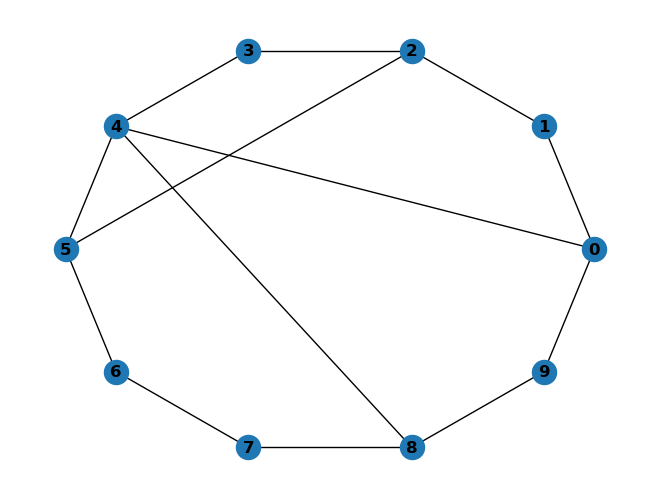

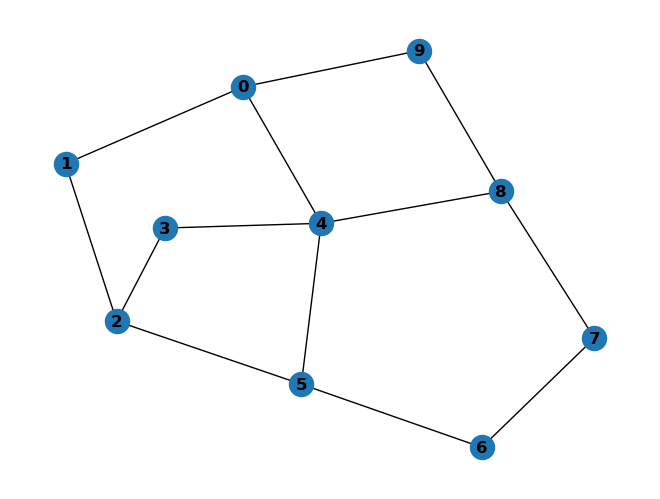

In [195]:
G = nx.Graph()
G.add_nodes_from([i for i in range(10)])
G.add_edges_from([(i,(i+1)% G.number_of_nodes() ) for i in range(10)])
G.add_edge(2,5)
G.add_edge(4,8)
G.add_edge(4,0)
for e in G.edges:
    G.edges[e]['weight'] = 1.0

# Now Draw the graph. First we will draw it with the nodes arranged on the circle, then we will draw the same graph 
# with the position of the nodes optimized for easier visualization
plt.figure(1)
nx.draw(G, with_labels=True, font_weight='bold', pos=nx.circular_layout(G))
plt.figure(2)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()



array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

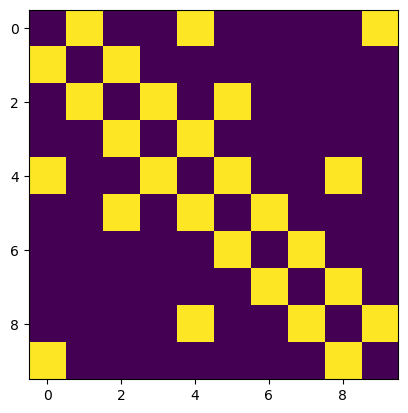

In [196]:
A = nx.adjacency_matrix(G).todense()
display(A)
plt.imshow(A);

### Add your BitString class below

In [197]:
class BitString:
    """
    Simple class to implement a config of bits
    """
    def __init__(self, N):
        self.N = N
        self.config = np.zeros(N, dtype=int) 

    def __repr__(self):
        return np.array2string(self.config)

    def __eq__(self, other): 
        #if every element between the two arrays is the same at all indexes, they are the same
        return (self.config == other.config).all()
    
    def __len__(self):
        return self.N

    def on(self):
        count = 0
        for element in self.config:
            if element == 1:
                count += 1
        return count
    
    def off(self):
        count = 0
        for element in self.config:
            if element == 0:
                count += 1
        return count
    
    def flip_site(self,i):
        current_bit = self.config[i]
        if current_bit == 0:
            self.config[i] = 1
        elif current_bit == 1:
            self.config[i] = 0
        else:
            raise ValueError(f"Error: Bit is not a 1 or 0. At index {i}, the value is {self.config[i]}")
 
    def int(self):
        decimal_number = 0
        length = len(self.config)
        for i in range(length):
            decimal_number += self.config[length - i - 1] * (2 ** i)
        return decimal_number

    def set_config(self, s:list[int]):
        try:
            self.config = np.array(s)
        except Exception as e:
            raise ValueError(f"Error: set_config failed {e}")
        
    def set_int_config(self, dec:int):
        #convert decimal to integer
        binary_representation = ''
        while dec > 0:
            remainder = dec % 2
            binary_representation = str(remainder) + binary_representation
            dec //= 2
        if not binary_representation:
            binary_representation = '0'

        #convert string to array

        #in order to add padding zeroes, create the correct dimension array of all zeroes
        temp = np.zeros(self.N, dtype=int)
        #index should start with the correct amount of padding zeroes in the front to ensure dimensions match
        index = self.N - len(binary_representation)
        #assign each digit in the string to an element of the array
        for digit in binary_representation:
            temp[index] = int(digit)
            index += 1
        #assign the internal array to this temporary array
        self.config = temp



In [198]:
def energy(bs: BitString, G: nx.Graph):
    """Compute energy of configuration, `bs`

        .. math::
            E = \\left<\\hat{H}\\right>

    Parameters
    ----------
    bs   : Bitstring
        input configuration
    G    : Graph
        input graph defining the Hamiltonian
    Returns
    -------
    energy  : float
        Energy of the input configuration
    """

    energy = 0.0
    for edge in G.edges():
        i, j = edge
        si = 1
        if bs.config[i] == 0:
            si = -1
        sj = 1
        if bs.config[j] == 0:
            sj = -1
        energy += G.edges[edge]['weight'] * si * sj

    return energy

### Naive minimization

Loop over all configurations and compute energies to find the lowest

 Lowest energy  -9.00000000: [0 0 1 0 1 0 0 1 0 1]


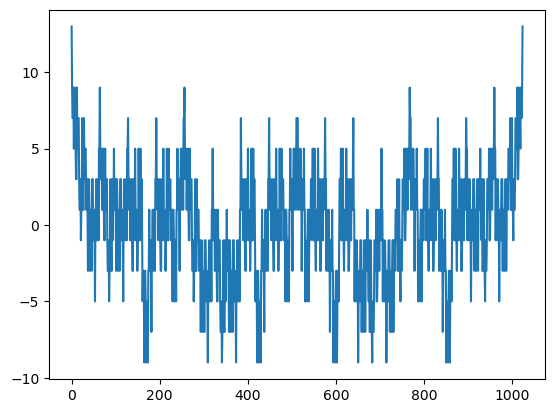

In [199]:
x = [] # Store list of indices
y = [] # Store list of energies
xmin = None # configuration of minimum energy configuration
emin = float('inf') # changed to allow algorithm to find the lowest energy by initially comparing it to largest amount
my_bs = BitString(10)

#iterate over all possible combinations of the bitstring, 2^n possibilities, where n is length of bitstring
for index in range(2**len(my_bs)):
    my_bs.set_int_config(index)
    
    # Compute energy for this configuration
    en = energy(my_bs, G)
    
    # Update minimum energy and bitstring if it is the smallest energy found so far
    if en < emin:
        emin = en
        xmin = index
        
    #Append appropriate values
    x.append(index)
    y.append(en)

# Print out all the energies
plt.plot(x,y)

# Print out the lowest energy configuration
my_bs.set_int_config(xmin)

print(" Lowest energy %12.8f: %s" %(emin, my_bs))
assert(abs(energy(my_bs, G) - -9) < 1e-12)


### Visualize ground state
Print out the graph again, this time coloring each node according to it's state (0 or 1)

Configuration: [0 0 1 0 1 0 0 1 0 1]


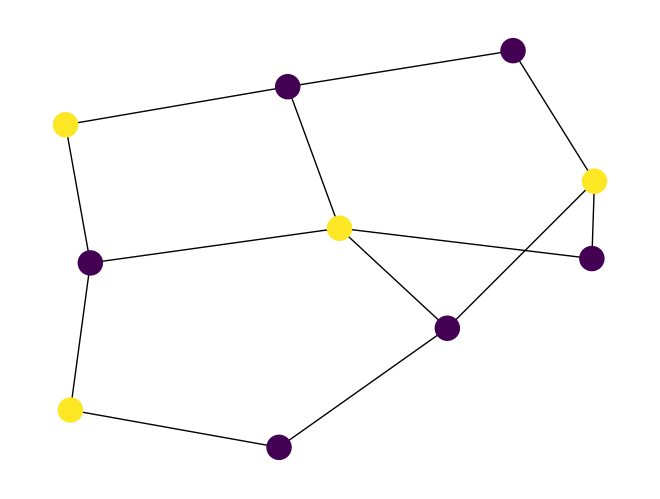

In [200]:
print("Configuration: %s" %my_bs)
nx.draw(G, node_color=my_bs.config)